<a href="https://colab.research.google.com/github/sergienko4/deep-learing/blob/main/ex10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Ex.10 - RNN

Submitted by: [... **your name and ID** ...]


In [111]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import SimpleRNN, LSTM # <--- recurrent layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
import re
print(tf.__version__)

2.7.0


In [112]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/MyDrive/ex10/war_and_peace.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***
### 1. Preprocess the text corpus

(if you are using google colab, remember to upload the corpus file first..)

In [113]:
# f = open('war_and_peace.txt','r') # open the corpus file
f = open(path,'r') 
text = f.read().lower()  # read file and convert to lower-case letters
data = text.replace('\n',' ')

data = re.sub(r'[^a-zA-Z0-9 ]',r'',data)

print('len(text) = ',len(text))

print(data[:400]) # print the first 400 characters..

len(text) =  3196213
well prince so genoa and lucca are now just family estates of the buonapartes but i warn you if you dont tell me that this means war if you still try to defend the infamies and horrors perpetrated by that antichristi really believe he is antichristi will have nothing more to do with you and you are no longer my friend no longer my faithful slave as you call yourself but how do you do i see i have 


- generate training sequences of `T=20` characters, by sampling the text corpus with a stride of 5 characters (i.e., each sequences starts 5 chars after the begining of the last sequences).

- generate a matching list, holding the `next_char` for each of your sequences.

- how many sequences did you extract in total? `N = ?`

- convert the sequences into a 1-hot representation, suitable for our model trainig:

`X.shape = (N, T, len(chars))`

`Y.shape = (N, len(chars))`

In [114]:
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))
print('chars = ',chars)

There are 3083435 total characters and 37 unique characters in your data.
chars =  [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [115]:
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# ix_to_char

In [116]:
T = 20  # extract training sequences of length T
stride = 5

sequences = []  # This holds our extracted sequences
next_chars = []  # This holds the targets (the follow-up character)

for i in range(0, len(data) - T, stride):
    sequences.append(data[i: i + T])
    next_chars.append(data[i + T])

In [117]:
X = np.zeros((len(sequences), T, len(chars)), dtype='bool')
Y = np.zeros((len(sequences), len(chars)), dtype='bool')

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_ix[char]] = 1
    Y[i, char_to_ix[next_chars[i]]] = 1
    
print('X.shape = (#examples, T, input-dim) =', X.shape)
print('Y.shape = (#examples, output-dim) =', Y.shape)

X.shape = (#examples, T, input-dim) = (616683, 20, 37)
Y.shape = (#examples, output-dim) = (616683, 37)


***
### 2. LTSM Model

- Build an `LTSM` model with 128 (hidden)-units that accepts the input sequences. Add a `Dense` layer on top of it, with `len(chars)` softmax units.

- Train the model for only 1 epoch (use: `RMSprop` and batch size of 128).



In [118]:
model = Sequential(name='LSTM_128')
model.add(Input(shape=(T, len(chars))))  # (12,27)
model.add(LSTM(128)) # 128 internal state units
model.add(Dense(len(chars), activation="softmax"))
model.summary()

Model: "LSTM_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 128)               84992     
                                                                 
 dense_7 (Dense)             (None, 37)                4773      
                                                                 
Total params: 89,765
Trainable params: 89,765
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

history = model.fit(X, Y, epochs=1, batch_size=128)

4818/4818 [==============================] - 19s 4ms/step - loss: 2.0254


### 3. Model predictions


- use the senternce `the meaning of life ` as an input to the model (convert it to 1-hot first..),

- plot the model's output as a probability distribution over the list of chars.

- sample a single char from that distribution, and add it to the generated sentence.

- update the 1-hot buffer, and continue the process for 99 more letters (using a loop).

- print the resulting sentence.

In [120]:
input = 'the meaning of life'

In [121]:
input_one_hot = np.zeros((len(input), T, len(chars)), dtype='bool')

In [122]:
input_one_hot.shape

(19, 20, 37)

In [123]:
y_hat = model.predict(input_one_hot)

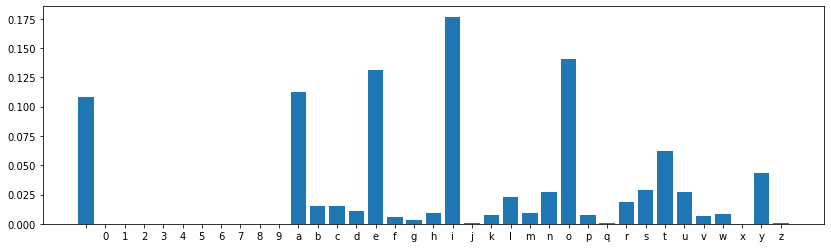

In [124]:
plt.figure(figsize=(14,4))
plt.bar(range(len(chars)), y_hat[0])
plt.xticks(range(len(chars)), labels=chars)
plt.show()

In [125]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of lifet all by hosk he papren frimply thement comout a bening ate poiceted with be the rome sores notha th


***
### 3. Fit your model

- Fit your model a bit more (try 10-20 epochs), and regenerate a new `N=100` sentence sample. Does it get any better?

- If you wish, you can try to train the model further, or you can try using a different corpus (dataset) for the training (you can even try a text in hebrew). Be creative ;)

In [126]:
history = model.fit(X, Y, epochs=20, batch_size=512)

Epoch 1/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.6765
Epoch 2/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.5844
Epoch 3/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.5228
Epoch 4/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.4772
Epoch 5/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.4417
Epoch 6/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.4132
Epoch 7/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3898
Epoch 8/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3701
Epoch 9/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3531
Epoch 10/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3384
Epoch 11/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3251
Epoch 12/20
1205/1205 [==============================] - 6s 5ms/step - loss: 1.3135
E

In [127]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

the meaning of life of the ponceov which they refulting he to let her most and pierre lakeness that the staff of life a


In [136]:
X.shape

(616683, 20, 37)

In [ ]:
#---------------------------------------------------freestyle---------------------------------------------------

In [ ]:
model_freestyle = Sequential(name='freestyle')
model_freestyle.add(LSTM(
        256,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True
    ))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(512, return_sequences=True))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(256))
model_freestyle.add(Dense(256))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(Dense(vocab_size))
model_freestyle.add(Activation('softmax'))
model_freestyle.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model_freestyle.summary()


In [ ]:
history = model_freestyle.fit(X, Y, epochs=50, batch_size=1024)

In [ ]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(100):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

In [ ]:
path='/content/drive/MyDrive/ex10/russian_troll_tweets_.txt'
# f = open('war_and_peace.txt','r') # open the corpus file
f = open(path,'r') 
text = f.read().lower()  # read file and convert to lower-case letters
data = text.replace('\n','.')

# data = re.sub(r'[^a-zA-Z0-9 ]',r'',data)

print('len(text) = ',len(text))

print(data[:400]) # print the first 400 characters..

chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))
print('chars = ',chars)

char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

T = 50  # extract training sequences of length T
stride = 10

sequences = []  # This holds our extracted sequences
next_chars = []  # This holds the targets (the follow-up character)

for i in range(0, len(data) - T, stride):
    sequences.append(data[i: i + T])
    next_chars.append(data[i + T])

X = np.zeros((len(sequences), T, len(chars)), dtype='bool')
Y = np.zeros((len(sequences), len(chars)), dtype='bool')

for i, seq in enumerate(sequences):
    for t, char in enumerate(seq):
        X[i, t, char_to_ix[char]] = 1
    Y[i, char_to_ix[next_chars[i]]] = 1

print('X.shape = (#examples, T, input-dim) =', X.shape)
print('Y.shape = (#examples, output-dim) =', Y.shape)

In [ ]:
model_freestyle = Sequential(name='freestyle')
model_freestyle.add(LSTM(
        256,
        input_shape=(X.shape[1], X.shape[2]),
        return_sequences=True
    ))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(512, return_sequences=True))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(LSTM(256))
model_freestyle.add(Dense(256))
model_freestyle.add(Dropout(0.3))
model_freestyle.add(Dense(vocab_size))
model_freestyle.add(Activation('softmax'))
model_freestyle.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model_freestyle.summary()

In [ ]:
history = model_freestyle.fit(X, Y, epochs=50, batch_size=1024)

Epoch 1/50
148/148 [==============================] - 13s 65ms/step - loss: 3.2693
Epoch 2/50
148/148 [==============================] - 10s 65ms/step - loss: 2.8500
Epoch 3/50
148/148 [==============================] - 10s 65ms/step - loss: 2.5140
Epoch 4/50
148/148 [==============================] - 10s 65ms/step - loss: 2.3068
Epoch 5/50
148/148 [==============================] - 10s 65ms/step - loss: 2.1430
Epoch 6/50
148/148 [==============================] - 10s 66ms/step - loss: 2.0019
Epoch 7/50
148/148 [==============================] - 10s 65ms/step - loss: 1.8842
Epoch 8/50
148/148 [==============================] - 10s 65ms/step - loss: 1.7859
Epoch 9/50
148/148 [==============================] - 10s 67ms/step - loss: 1.7040
Epoch 10/50
148/148 [==============================] - 10s 65ms/step - loss: 1.6309
Epoch 11/50
148/148 [==============================] - 10s 66ms/step - loss: 1.5711
Epoch 12/50
148/148 [==============================] - 10s 67ms/step - loss: 1.5149
E

In [ ]:
input_buffer = input_one_hot[0]
generated_text = input

yy = []
for i in range(200):
    yhat = model.predict(input_buffer[None,:])
    # sample the next character:
    # ix = np.argmax(yhat)
    ix = np.random.choice(range(len(chars)), p=yhat[0])
    ch = ix_to_char[ix]
    generated_text += ch
    # update the input buffer:
    input_buffer = np.r_[input_buffer[1:,:], np.zeros((1,len(chars)))]
    input_buffer[-1,ix] = 1
    yy.append(yhat)
print(generated_text)

***
## Good Luck!